In [22]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from functions.load_datasets import load_datasets
from functions.calculate_monthly_returns import calculate_monthly_returns


In [23]:
base_path = str(project_root) + "/data/"
df_pbr, df_stp, df_mktcap = load_datasets(base_path)
df_returns = calculate_monthly_returns(df_stp)

In [24]:
# データ構造の確認
print("df_pbrの形状:", df_pbr.shape)
print("df_stpの形状:", df_stp.shape)
print("\ndf_pbrの最初の数行:")
print(df_pbr.head())

df_pbrの形状: (3474, 73)
df_stpの形状: (3474, 73)

df_pbrの最初の数行:
       Company  2020/01  2020/02  2020/03  2020/04  2020/05  2020/06  2020/07  \
0  あい　ホールディングス   2.2368   1.7446   1.5249   1.5318   1.6520   1.7778   1.6005   
1       あおぞら銀行   0.7223   0.6589   0.5028   0.4714   0.5545   0.5196   0.4279   
2       あかつき本社   0.9728   0.8228   0.7322   0.6954   0.7066   0.6684   0.6532   
3         あさくま   2.2664   2.1353   1.9538   1.8828   2.0097   1.9716   1.9469   
4          あさひ   1.2066   0.9894   1.0279   1.2032   1.4412   1.3145   1.4257   

   2020/08  2020/09  ...  2025/03  2025/04  2025/05  2025/06  2025/07  \
0   2.0292   2.2111  ...   1.1067   1.1269   1.2310   1.2540   1.2947   
1   0.4832   0.4421  ...   0.6449   0.6156   0.6497   0.6702   0.6874   
2   0.7471   0.7525  ...   1.0117   0.9815   0.9448   0.9600   1.0115   
3   2.2212   2.2451  ...   7.0426   7.1215   7.4109   7.4399   7.3122   
4   1.6119   1.5210  ...   0.9777   0.9291   0.9116   0.8570   0.8692   

   2025/08  202

In [25]:
# PBRによる5分位ポートフォリオ構築
def create_quintile_portfolios(df_pbr, df_returns, n_quintiles=5):
    """
    PBRで5分位ポートフォリオを構築し、各分位の月次リターンを計算
    """
    # PBRの日付列を取得
    pbr_cols = [col for col in df_pbr.columns if col != 'Company']

    # リターン列を取得
    return_cols = [col for col in df_returns.columns if col.startswith('ret_')]

    # 結果を格納する辞書
    portfolio_returns = {f'Q{i+1}': [] for i in range(n_quintiles)}
    portfolio_returns['Date'] = []

    # 各月について処理
    for i in range(len(pbr_cols) - 1):
        formation_month = pbr_cols[i]  # ポートフォリオ形成月のPBR
        return_month = return_cols[i]  # 翌月のリターン

        # 形成月の日付を取得
        portfolio_returns['Date'].append(return_month.replace('ret_', ''))

        # PBRとリターンをマージ
        temp_df = pd.DataFrame({
            'Company': df_pbr['Company'],
            'PBR': df_pbr[formation_month],
            'Return': df_returns[return_month]
        })

        # 欠損値を除外
        temp_df = temp_df.dropna()

        if len(temp_df) < n_quintiles:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            continue

        # PBRで5分位に分割（Q1が最も低いPBR = バリュー株）
        temp_df['Quintile'] = pd.qcut(temp_df['PBR'], q=n_quintiles, labels=False, duplicates='drop')

        # 各分位の等加重平均リターンを計算
        for q in range(n_quintiles):
            quintile_returns = temp_df[temp_df['Quintile'] == q]['Return']
            avg_return = quintile_returns.mean() if len(quintile_returns) > 0 else np.nan
            portfolio_returns[f'Q{q+1}'].append(avg_return)

    # DataFrameに変換
    result_df = pd.DataFrame(portfolio_returns)
    result_df = result_df.set_index('Date')

    return result_df

# 5分位ポートフォリオを構築
quintile_returns = create_quintile_portfolios(df_pbr, df_returns, n_quintiles=5)

print("5分位ポートフォリオの月次リターン")
print(f"データ期間: {quintile_returns.index[0]} ～ {quintile_returns.index[-1]}")
print(f"観測数: {len(quintile_returns)}")
print(f"\n基本統計量:")
print(quintile_returns.describe())

5分位ポートフォリオの月次リターン
データ期間: 2020/02 ～ 2025/12
観測数: 71

基本統計量:
              Q1         Q2         Q3         Q4         Q5
count  71.000000  71.000000  71.000000  71.000000  71.000000
mean    1.220780   1.097599   0.976198   0.666960   0.428379
std     3.598950   3.514951   3.770651   4.272698   5.515837
min   -12.983340 -13.619971 -14.457858 -16.563131 -18.083532
25%    -0.684922  -0.210098  -0.516029  -0.877283  -2.052067
50%     1.828067   1.419262   1.169082   0.876261   0.642227
75%     3.557314   3.099235   2.942504   3.004711   3.750113
max     7.039707   8.204652   9.140417  11.710877  16.078743


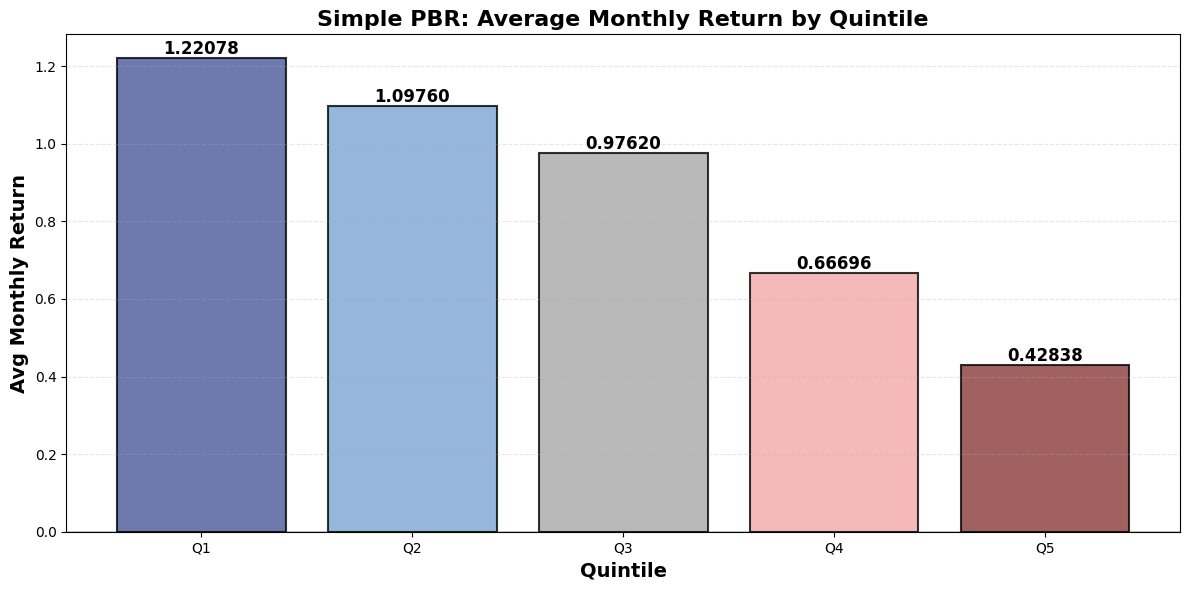


各分位の平均月次リターン:
Q1: 1.22078 (122.078%)
Q2: 1.09760 (109.760%)
Q3: 0.97620 (97.620%)
Q4: 0.66696 (66.696%)
Q5: 0.42838 (42.838%)


In [26]:
# 図1: 平均月次リターンのヒストグラム（棒グラフ）
plt.figure(figsize=(12, 6))

mean_returns = quintile_returns.mean()
colors = ['#4A5899', '#7AA5D2', '#A8A8A8', '#F4A8A8', '#8B3A3A']

bars = plt.bar(mean_returns.index, mean_returns.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

plt.xlabel('Quintile', fontsize=14, fontweight='bold')
plt.ylabel('Avg Monthly Return', fontsize=14, fontweight='bold')
plt.title('Simple PBR: Average Monthly Return by Quintile', fontsize=16, fontweight='bold')
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.grid(True, alpha=0.3, axis='y', linestyle='--')

# 値をバーの上に表示
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.5f}', ha='center', va='bottom' if height > 0 else 'top',
            fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n各分位の平均月次リターン:")
for q, ret in mean_returns.items():
    print(f"{q}: {ret:.5f} ({ret*100:.3f}%)")

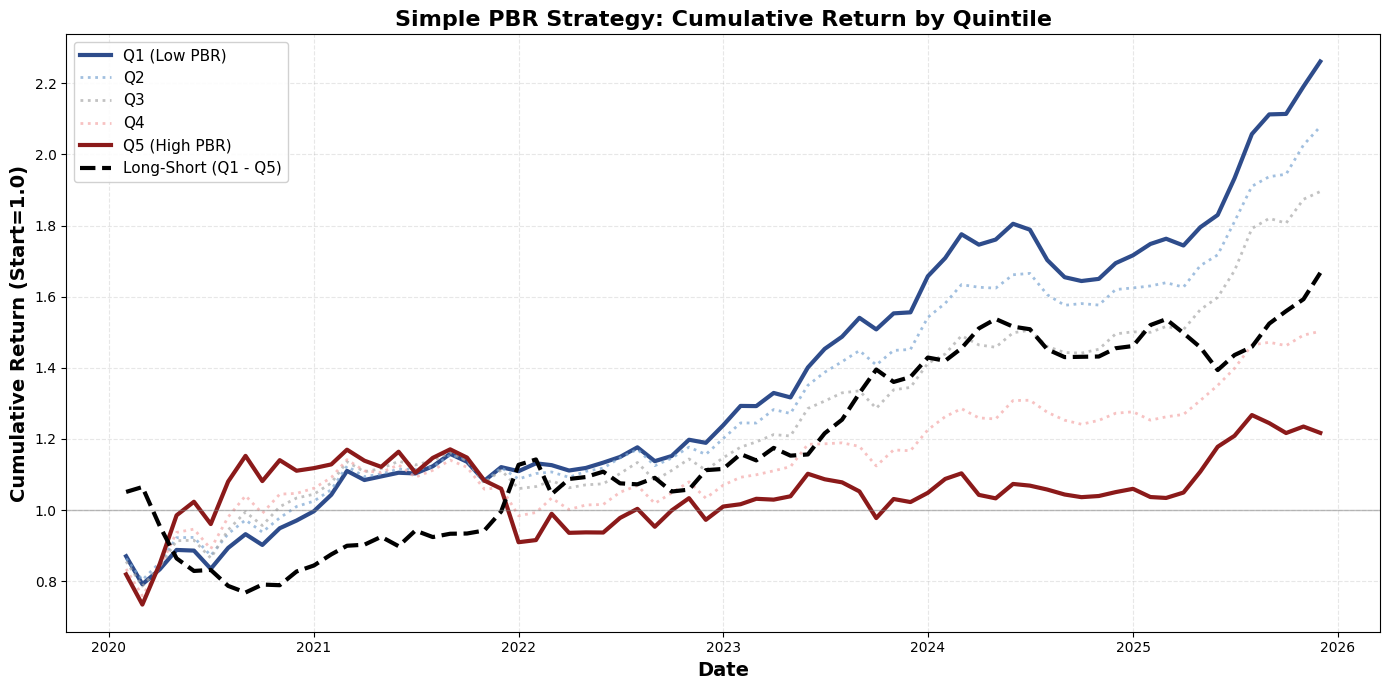


最終累積リターン（開始=1.0）:
Q1: 2.2612 (累積リターン: +126.12%)
Q2: 2.0781 (累積リターン: +107.81%)
Q3: 1.8956 (累積リターン: +89.56%)
Q4: 1.5027 (累積リターン: +50.27%)
Q5: 1.2170 (累積リターン: +21.70%)
Long-Short (Q1-Q5): 1.6669 (累積リターン: +66.69%)


In [27]:
# 図2: 累積リターンの推移
plt.figure(figsize=(14, 7))

# 累積リターンを計算（1から始まる）
# リターンはパーセントで格納されているので、100で割って小数に変換
cumulative_returns = (1 + quintile_returns / 100).cumprod()

# Long-Short (Q1 - Q5) ポートフォリオの累積リターン
long_short_returns = quintile_returns['Q1'] - quintile_returns['Q5']
cumulative_long_short = (1 + long_short_returns / 100).cumprod()

# 日付インデックスをdatetimeに変換
dates = pd.to_datetime(cumulative_returns.index, format='%Y/%m')

# 各分位の累積リターンをプロット
plt.plot(dates, cumulative_returns['Q1'], linewidth=3, color='#2E4C8B', label='Q1 (Low PBR)', linestyle='-')
plt.plot(dates, cumulative_returns['Q2'], linewidth=2, color='#7AA5D2', label='Q2', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns['Q3'], linewidth=2, color='#A8A8A8', label='Q3', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns['Q4'], linewidth=2, color='#F4A8A8', label='Q4', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns['Q5'], linewidth=3, color='#8B1A1A', label='Q5 (High PBR)', linestyle='-')
plt.plot(dates, cumulative_long_short, linewidth=3, color='black', label='Long-Short (Q1 - Q5)', linestyle='--')

plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Return (Start=1.0)', fontsize=14, fontweight='bold')
plt.title('Simple PBR Strategy: Cumulative Return by Quintile', fontsize=16, fontweight='bold')
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.axhline(y=1, color='gray', linestyle='-', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# 最終累積リターンの表示
print("\n最終累積リターン（開始=1.0）:")
for col in cumulative_returns.columns:
    final_return = cumulative_returns[col].iloc[-1]
    total_return_pct = (final_return - 1) * 100
    print(f"{col}: {final_return:.4f} (累積リターン: {total_return_pct:+.2f}%)")

final_ls = cumulative_long_short.iloc[-1]
total_ls_pct = (final_ls - 1) * 100
print(f"Long-Short (Q1-Q5): {final_ls:.4f} (累積リターン: {total_ls_pct:+.2f}%)")

In [28]:
# バリュープレミアムの統計分析
value_premium = quintile_returns['Q1'] - quintile_returns['Q5']

print("\n" + "=" * 80)
print("バリュープレミアム（Q1 - Q5）の統計分析")
print("=" * 80)
print(f"平均月次プレミアム: {value_premium.mean():.5f} ({value_premium.mean()*100:.3f}%)")
print(f"標準偏差: {value_premium.std():.5f}")
print(f"t値: {value_premium.mean() / (value_premium.std() / np.sqrt(len(value_premium))):.4f}")

# t検定
from scipy import stats
t_stat, p_value = stats.ttest_1samp(value_premium.dropna(), 0)
print(f"p値: {p_value:.6f}")

if p_value < 0.01:
    sig = '***'
elif p_value < 0.05:
    sig = '**'
elif p_value < 0.1:
    sig = '*'
else:
    sig = ''

print(f"有意性: {sig} ({'有意' if sig else '有意でない'})")
print(f"\n勝率（プレミアムが正の月）: {(value_premium > 0).sum() / len(value_premium) * 100:.2f}%")
print("=" * 80)


バリュープレミアム（Q1 - Q5）の統計分析
平均月次プレミアム: 0.79240 (79.240%)
標準偏差: 3.76431
t値: 1.7737
p値: 0.080456
有意性: * (有意)

勝率（プレミアムが正の月）: 67.61%


In [29]:
# シャープレシオの計算
print("\n" + "=" * 80)
print("シャープレシオの計算（リスクフリーレート = 0と仮定）")
print("=" * 80)

# 各分位のシャープレシオ
sharpe_ratios = {}
for col in quintile_returns.columns:
    mean_return = quintile_returns[col].mean()
    std_return = quintile_returns[col].std()
    # 月次シャープレシオ
    sharpe_monthly = mean_return / std_return if std_return > 0 else 0
    # 年率換算シャープレシオ = 月次シャープレシオ × sqrt(12)
    sharpe_annual = sharpe_monthly * np.sqrt(12)
    sharpe_ratios[col] = {
        '月次': sharpe_monthly,
        '年率換算': sharpe_annual
    }

# Long-Short戦略のシャープレシオ
ls_mean = value_premium.mean()
ls_std = value_premium.std()
ls_sharpe_monthly = ls_mean / ls_std if ls_std > 0 else 0
ls_sharpe_annual = ls_sharpe_monthly * np.sqrt(12)

sharpe_ratios['Long-Short (Q1-Q5)'] = {
    '月次': ls_sharpe_monthly,
    '年率換算': ls_sharpe_annual
}

# 結果を表示
sharpe_df = pd.DataFrame(sharpe_ratios).T
print("\nシャープレシオ:")
print(sharpe_df.to_string())

print("\n" + "=" * 80)
print("解釈:")
print("-" * 80)
print("- シャープレシオ = 平均リターン / リターンの標準偏差")
print("- リスク調整後のパフォーマンスを測定")
print("- 一般的に、シャープレシオ > 1 は良好、> 2 は優秀とされる")
print("=" * 80)


シャープレシオの計算（リスクフリーレート = 0と仮定）

シャープレシオ:
                          月次      年率換算
Q1                  0.339204  1.175039
Q2                  0.312266  1.081720
Q3                  0.258894  0.896834
Q4                  0.156098  0.540740
Q5                  0.077663  0.269034
Long-Short (Q1-Q5)  0.210504  0.729207

解釈:
--------------------------------------------------------------------------------
- シャープレシオ = 平均リターン / リターンの標準偏差
- リスク調整後のパフォーマンスを測定
- 一般的に、シャープレシオ > 1 は良好、> 2 は優秀とされる
